In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import scipy.stats as stats
!pip install slycot
!pip install control
import control as ct
import seaborn as sb

!pip3 install pysindy
import pysindy as ps

from scipy import signal
import sklearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 3.0 MB 12.4 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for slycot: filename=slycot-0.5.0-cp37-cp37m-linux_x86_64.whl size=2021297 sha256=8e50ac2ef81527179da0de4d518393decc682b9ea92a6d30c73d8750cf5f6e86
  Stored in directory: /root/.cache/pip/wheels/7f/2e/54/e2cb7cf358f956ed0efa9923ab4f5aa353a941422c55b25531
Successfully built slycot
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 398 kB 17.1 MB/s 
  Created wheel for control: filename=control-0.9.2-py2.py3-none-any.whl size=403205 sha256=e24280ad735a23d5f03a8e9dc31d92822435972898d23daa1d3a8c06e7d1c6d6
  Stored in directory: /root/.cache/pip/wheels/48/ef/c2/929bb5c59a1328df00a0561d0e68cd7c8537f33f5ce0ce741b


## function definitions

In [ ]:
def SINDY_delays_3d(shape_factors, scale_factors, loc_factors, t, forcing, response, final_run, poly_degree):
  shape_time = np.arange(0,len(t),1) # analogous to drainage_time
  # shapes is analogous to "drainage" in original code
  feature_names=['response']# , 'forcing']
  shapes = np.zeros(shape=(len(t), len(shape_factors)))
  for shape_idx in range(0,len(shape_factors)):
    for idx in range(0,len(t)):
      if (abs(forcing[idx]) > 10**-6): # when nonzero forcing occurs
        if (idx == int(0)):

          shapes[idx:,shape_idx] = shapes[idx:,shape_idx] + forcing[idx]*stats.gamma.pdf(shape_time, shape_factors[shape_idx], scale=scale_factors[shape_idx], loc = loc_factors[shape_idx]) 

        else:
          shapes[idx:,shape_idx] = shapes[idx:,shape_idx] + forcing[idx]*stats.gamma.pdf(shape_time[:-idx], shape_factors[shape_idx], scale=scale_factors[shape_idx], loc = loc_factors[shape_idx]) 


    feature_names.append(str("forcing" + str(shape_idx + 1)) )
  
  # SINDy
  model = ps.SINDy(
      differentiation_method= ps.SmoothedFiniteDifference(),
      feature_library=ps.PolynomialLibrary(degree=poly_degree,include_bias = False, include_interaction=False), 
      optimizer = ps.STLSQ(threshold=0), 
      feature_names = feature_names
  )

  #U = np.concatenate((np.reshape(forcing,(-1,1)), shapes) , axis=1)
  #if (any(shapes == np.inf)):
  #  print("infinite value in U")
  #U = np.nan_to_num(shapes,nan=0.0, posinf=np.finfo(np.float64).max, neginf=np.finfo(np.float64).min)
  U = shapes
  model.fit(response,t=t,u=U)
  #model.print()
  #print("score = ",model.score(response,t=t,u=U)) # training data score

  mae = 10**6 # placeholder, shows simulation diverged or wasn't final run
  rmse = 10**6
  simulated = np.ones(shape=(len(response[1:]),1))*np.mean(response)
  if (final_run): 
    
    print("number of lines:")
    print(len(shape_factors))
    plt.figure(figsize=(20,10))
    plt.plot(U)
    plt.title("final input transformations")
    plt.show()
    '''
    plt.figure(figsize=(5,5))
    plt.title("input transformation parameters")
    plt.scatter(loc_factors, shape_factors)
    plt.xlabel("location")
    plt.ylabel("shape")
    plt.show()
    '''

    model.print(precision=5)
    print("score = ",model.score(response,t=t,u=U)) # training data score

    try: # in case simulation diverges
      y = np.reshape(response,(-1,1)) # to match simulation results dimension
      simulated = model.simulate([response[1]],t=t,u=U)

      fig, ax1 = plt.subplots(figsize=(20,10))
      ax2 = ax1.twinx()
      plt.title(str("polynomial degree = "+ str(poly_degree)))

      line1 = ax1.plot(t[1:],y[1:],'r-.',label='measurements')
      line2 = ax1.plot(t[1:],simulated[:len(t)-1],'g--',label='SINDy')
      ax1.set_xlabel(r'Time ($min$)')
      ax1.set_ylabel(r'response magnitude')
      ax1.set_ylim([1.2*min(y),1.2*max(y)])

      line3 = ax2.plot(t[1:],forcing[1:],'b',label='forcing')
      ax2.set_ylabel("forcing intensity")

      line4 = ax2.plot(t[1:], shapes[1:] * ( np.max(forcing) / np.max(shapes  ) ) , 'k--', label='transformed forcing (scaled)', alpha=0.35)
      
      lns = line1+line2+line3+line4
      labs = [l.get_label() for l in lns]
      plt.legend(lns, labs, loc=0,ncol=3)


      plt.show()
      
      mae = np.mean(np.abs(simulated[:len(t)-1]-y[1:])) # mean absolute error
      print("Simulation MAE = ", mae)
      rmse = np.sqrt(np.mean((simulated[:len(t)-1]-y[1:])**2)) # root mean squared error
      print("Simulation RMSE = ", rmse)


    except:
      print("Simulation diverged.")


    


  return [model.score(response,t=t,u=U), model, mae, rmse, t[1:], simulated[:len(t)-1] , response[1:] , forcing[1:] , U]

# takes np array X and assumes the zeroeth column is the forcing
def optimize_lag_shapes(polyorder, target, init_num_lines, max_num_lines, X,max_iter):
  # this is significantly modified to track the optimization, it's not as efficient as the normal version

  # tracking changes to input transformation for optimization figure
  track_shapes = list()
  track_scales = list()
  track_locations = list()
  track_scores = list()



  results = list()

  rates_of_change = abs(np.diff(X[:,target]))
  biggest_movers = np.flip(np.argsort(rates_of_change))
  maxes = np.array([biggest_movers[0]])
  if (maxes[0] < 1):
    maxes[0] = 1 # lower bound shape at 1

  # if a close neighbor is already selected, don't want that to be a starting point
  for index in range(0,len(biggest_movers)):
    if ( (abs(biggest_movers[index] - maxes) > int(len(X) / 1000*init_num_lines)).all()   ): 
      # more than some fraction of the total length apart
      # using init_num_lines strikes a balance between starting evenly spaced 
      # and starting all clustered on the steep regions
      if (biggest_movers[index] < 1):
        maxes = np.append(maxes,1) 
      else:
        maxes = np.append(maxes,float(biggest_movers[index]))
    if (len(maxes) >= max_num_lines):
      break

  previous_best = 0

  shape_factors = np.array([])
  scale_factors = np.array([])
  loc_factors = np.array([])
  speeds =  list([200,50,10,5,2, 1.1, 1.05, 1.01, 1.001])
  
  for num_lines in range(init_num_lines,max_num_lines):
    #print(num_lines)
    #speed = 6.4 # how far we'll jump around initially
    speed_idx = 0
    speed = speeds[speed_idx]

    if (len(shape_factors) == 0):  # if we're starting right now
      # start sharp
      #loc_factors = maxes[0:init_num_lines]
      #scale_factors = np.ones(len(loc_factors))
      #shape_factors = np.ones(len(scale_factors))

      # start dull
      shape_factors = maxes[0:init_num_lines]
      scale_factors = np.ones(shape = shape_factors.shape)
      loc_factors = np.ones(shape = shape_factors.shape)

      
    else:
      # start dull
      sharp_cand = maxes[num_lines]
      delay_cand = 1
      loc_cand = 1

      # start sharp
      #delay_cand = 1
      #sharp_cand = 1
      #loc_cand = biggest_movers[-num_lines*3]
      shape_factors = np.append(shape_factors, sharp_cand)
      scale_factors = np.append(scale_factors, delay_cand)
      loc_factors = np.append(loc_factors, loc_cand)

    # changed prev model to true for verbose output
    prev_model = SINDY_delays_3d(shape_factors, scale_factors, loc_factors, np.arange(0,len(X)), X[:,0], X[:,target],False, polyorder )

    print("\nInitial model:\n")
    print("score")
    print(prev_model[0])
    print("shape factors")
    print(shape_factors)
    print("scale factors")
    print(scale_factors)
    print("location factors")
    print(loc_factors)
    print("")

    for iterations in range(0,max_iter ):
      track_scores.append(prev_model[0])
      track_shapes.append(shape_factors[0])
      track_scales.append(scale_factors[0])
      track_locations.append(loc_factors[0])

      tuning_line = iterations % num_lines

      sooner_locs = np.array(loc_factors)
      sooner_locs[tuning_line-1] = float(loc_factors[tuning_line-1] - speed*len(X)/10**4  )
      if ( sooner_locs[tuning_line-1] < 0):
        sooner = np.zeros(len(prev_model))
      else:
        sooner = SINDY_delays_3d(shape_factors ,scale_factors ,sooner_locs, 
          np.arange(0,len(X)), X[:,0], X[:,target], False, polyorder )
        
      track_scores.append(sooner[0])
      track_shapes.append(shape_factors[0])
      track_scales.append(scale_factors[0])
      track_locations.append(sooner_locs[0])
      
      
      later_locs = np.array(loc_factors)
      later_locs[tuning_line-1] = float ( loc_factors[tuning_line-1]  +   1.01*speed*len(X)/10**4 )
      later = SINDY_delays_3d(shape_factors , scale_factors,later_locs, 
          np.arange(0,len(X)), X[:,0], X[:,target], False, polyorder )
      
      track_scores.append(later[0])
      track_shapes.append(shape_factors[0])
      track_scales.append(scale_factors[0])
      track_locations.append(later_locs[0])

      shape_up = np.array(shape_factors)
      shape_up[tuning_line-1] = float ( shape_factors[tuning_line-1]*speed*1.01 )
      shape_upped = SINDY_delays_3d(shape_up , scale_factors, loc_factors, 
                                np.arange(0,len(X)), X[:,0], X[:,target], False, polyorder )
      

      track_scores.append(shape_upped[0])
      track_shapes.append(shape_up[0])
      track_scales.append(scale_factors[0])
      track_locations.append(loc_factors[0])
      
      shape_down = np.array(shape_factors)
      shape_down[tuning_line-1] = float ( shape_factors[tuning_line-1]/speed )
      if (shape_down[tuning_line-1] < 1):
        shape_downed = np.zeros(len(prev_model)) # return a score of zero as this is illegal
      else:
        shape_downed = SINDY_delays_3d(shape_down , scale_factors, loc_factors, 
                                np.arange(0,len(X)), X[:,0], X[:,target], False, polyorder )


      track_scores.append(shape_downed[0])
      track_shapes.append(shape_down[0])
      track_scales.append(scale_factors[0])
      track_locations.append(loc_factors[0])

      scale_up = np.array(scale_factors)
      scale_up[tuning_line-1] = float(  scale_factors[tuning_line-1]*speed*1.01 )
      scaled_up = SINDY_delays_3d(shape_factors , scale_up, loc_factors, 
                                np.arange(0,len(X)), X[:,0], X[:,target], False, polyorder )


      track_scores.append(scaled_up[0])
      track_shapes.append(shape_factors[0])
      track_scales.append(scale_up[0])
      track_locations.append(loc_factors[0])

      scale_down = np.array(scale_factors)
      scale_down[tuning_line-1] = float ( scale_factors[tuning_line-1]/speed )
      scaled_down = SINDY_delays_3d(shape_factors , scale_down, loc_factors, 
                                np.arange(0,len(X)), X[:,0], X[:,target], False, polyorder )
      

      track_scores.append(scaled_down[0])
      track_shapes.append(shape_factors[0])
      track_scales.append(scale_down[0])
      track_locations.append(loc_factors[0])

      # rounder
      rounder_shape = np.array(shape_factors)
      rounder_shape[tuning_line-1] = shape_factors[tuning_line-1]*(speed*1.01)
      rounder_scale = np.array(scale_factors)
      rounder_scale[tuning_line-1] = scale_factors[tuning_line-1]/(speed*1.01)
      rounder = SINDY_delays_3d(rounder_shape , rounder_scale, loc_factors, 
                                np.arange(0,len(X)), X[:,0], X[:,target], False, polyorder )
      

      track_scores.append(rounder[0])
      track_shapes.append(rounder_shape[0])
      track_scales.append(rounder_scale[0])
      track_locations.append(loc_factors[0])

      # sharper
      sharper_shape = np.array(shape_factors)
      sharper_shape[tuning_line-1] = shape_factors[tuning_line-1]/speed
      sharper_scale = np.array(scale_factors)
      sharper_scale[tuning_line-1] = scale_factors[tuning_line-1]*speed
      if (sharper_shape[tuning_line -1] < 1):
        sharper = np.zeros(len(prev_model)) # lower bound on shape to avoid inf
      else:
        sharper = SINDY_delays_3d(sharper_shape ,sharper_scale,loc_factors, 
                                  np.arange(0,len(X)), X[:,0], X[:,target], False, polyorder )


      track_scores.append(sharper[0])
      track_shapes.append(sharper_shape[0])
      track_scales.append(sharper_scale[0])
      track_locations.append(loc_factors[0])

      scores = [prev_model[0], shape_upped[0], shape_downed[0], scaled_up[0], scaled_down[0], sooner[0], later[0], rounder[0], sharper[0] ]
      #print(scores)
      if (sooner[0] >= max(scores)):
        prev_model = sooner
        loc_factors = sooner_locs
      elif (later[0] >= max(scores)):
        prev_model = later
        loc_factors = later_locs

      elif(shape_upped[0] >= max(scores)):
        prev_model = shape_upped
        shape_factors = shape_up
      elif(shape_downed[0] >=max(scores)):
        prev_model = shape_downed
        shape_factors = shape_down

      elif(scaled_up[0] >= max(scores)):
        prev_model = scaled_up
        scale_factors = scale_up
      elif(scaled_down[0] >= max(scores)):
        prev_model = scaled_down
        scale_factors = scale_down


      elif (rounder[0] >= max(scores)):
        prev_model = rounder
        shape_factors = np.array(rounder_shape)
        scale_factors = np.array(rounder_scale)
      elif (sharper[0] >= max(scores)):
        prev_model = sharper
        shape_factors = np.array(sharper_shape)
        scale_factors = np.array(sharper_scale)


      elif( (num_lines - 1) == tuning_line): # the middle was best, but it's bad, tighten up the bounds (if we're at the last tuning line)
        
        speed_idx = speed_idx + 1
        
        if (speed_idx >= len(speeds)):
          break
        speed = speeds[speed_idx]
        
        '''
        if (speed > 10):
          speed = speed*0.5 # coarse tuning
          
        elif(speed > 1.3):
          speed = speed*0.8 # fine tuning
        else:
          speed = speed*0.95 # very fine tuning
        '''
        print("\nprevious, shape up, shape down, scale up, scale down, sooner, later, rounder, sharper")
        
        print(scores)
        track_scores.append(scores[0])
        print(len(track_scores))
        print("speed")
        print(speed)
        print("shape factors")
        print(shape_factors)
        track_shapes.append(shape_factors[0])
        print("scale factors")
        print(scale_factors)
        track_scales.append(scale_factors[0])
        print("location factors")
        print(loc_factors)
        track_locations.append(loc_factors[0])
        print("iteration no:")
        print(iterations)
        print("\n")
        
        #print(scores)
        if (speed < 1):
          print("converged, max accuracy for number of lines")
          break
    
    
    final_model = SINDY_delays_3d(shape_factors, scale_factors ,loc_factors,np.arange(0,len(X)), X[:,0], X[:,target], True, polyorder )
    results.append([final_model, shape_factors, scale_factors, loc_factors])
    if ((previous_best and final_model[0] - previous_best[0] < 0.005) or ( previous_best and final_model[0] - previous_best[0] < 0.01 and final_model[2] > previous_best[2] )): 
      # marginal (less than half percent improvement) OR somewhat marginal improvement in fit and worse mae
      break # we can be done
    else:
      previous_best = final_model
  winning_model = None
  best_mae = np.Inf
  for num_lines in range(len(results)):
    if (results[num_lines][0][2] < best_mae):
      winning_model = results[num_lines]
      best_mae = results[num_lines][0][2]

  return [winning_model, track_shapes, track_scales, track_locations, track_scores]
    
def transform_input(shape_factors, scale_factors, loc_factors,t, forcing):
  shape_time = np.arange(0,len(t),1) # analogous to drainage_time
  # shapes is analogous to "drainage" in original code
  feature_names=['response']# , 'forcing']
  shapes = np.zeros(shape=(len(t), len(shape_factors)))
  for shape_idx in range(0,len(shape_factors)):
    for idx in range(0,len(t)):
      if (abs(forcing[idx]) > 10**-6): # when nonzero forcing occurs
        if (idx == int(0)):

          shapes[idx:,shape_idx] = shapes[idx:,shape_idx] + forcing[idx]*stats.gamma.pdf(shape_time, shape_factors[shape_idx], scale=scale_factors[shape_idx], loc = loc_factors[shape_idx]) 

        else:
          shapes[idx:,shape_idx] = shapes[idx:,shape_idx] + forcing[idx]*stats.gamma.pdf(shape_time[:-idx], shape_factors[shape_idx], scale=scale_factors[shape_idx], loc = loc_factors[shape_idx]) 

  return shapes 


# figure showing gamma distributions with different parameter values

Text(0.5, 1.0, 'Approximating unit hydrographs with gamma distributions')

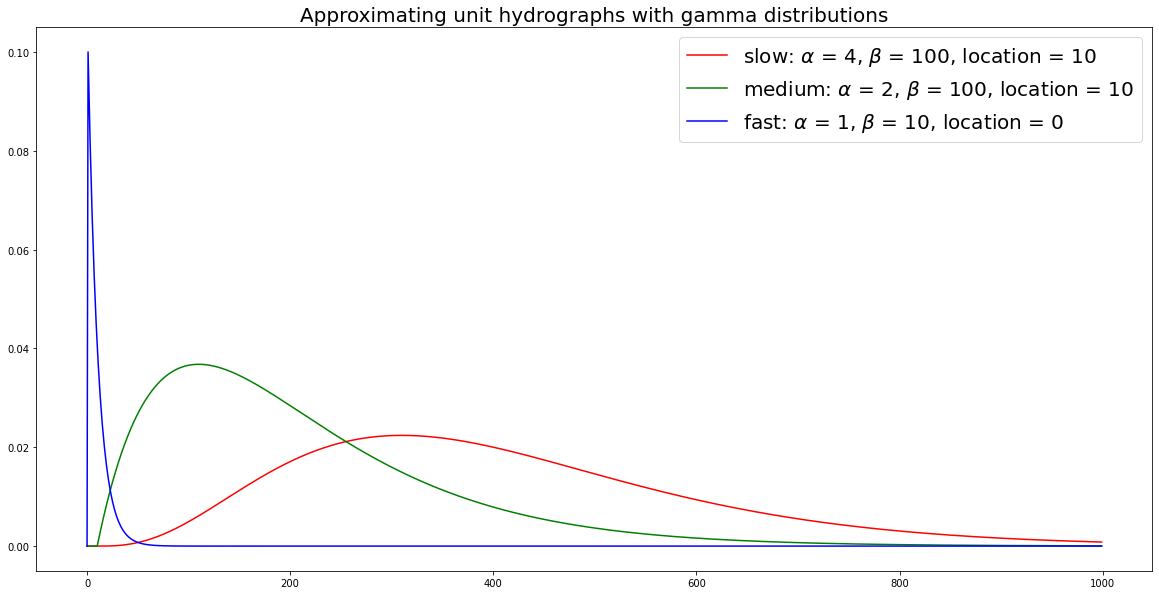

In [ ]:
t = np.arange(0,1000)

slow = 10*stats.gamma.pdf(t, 4,scale=100, loc=10) 
medium = 10*stats.gamma.pdf(t, 2, scale=100, loc=10)
fast  = stats.gamma.pdf(t,1,scale=10,loc=1)
delayed_pulse = .1*stats.gamma.pdf(t,1,scale=1,loc=300)
plt.figure(figsize=(20,10))
plt.plot(slow,'r',label=r'slow: $\alpha$ = 4, $\beta$ = 100, location = 10')
plt.plot(medium,'g',label=r'medium: $\alpha$ = 2, $\beta$ = 100, location = 10')
plt.plot(fast,'b',label=r'fast: $\alpha$ = 1, $\beta$ = 10, location = 0')
#plt.plot(delayed_pulse,'k',label=r'delayed pulse: $\alpha$ = 1, $\beta$ = 1, location = 300')
plt.legend(fontsize=20)
#plt.title("Gamma Distributions have high flexibility through three parameters",fontsize=20)
plt.title("Approximating unit hydrographs with gamma distributions", fontsize=20)

# input transformation

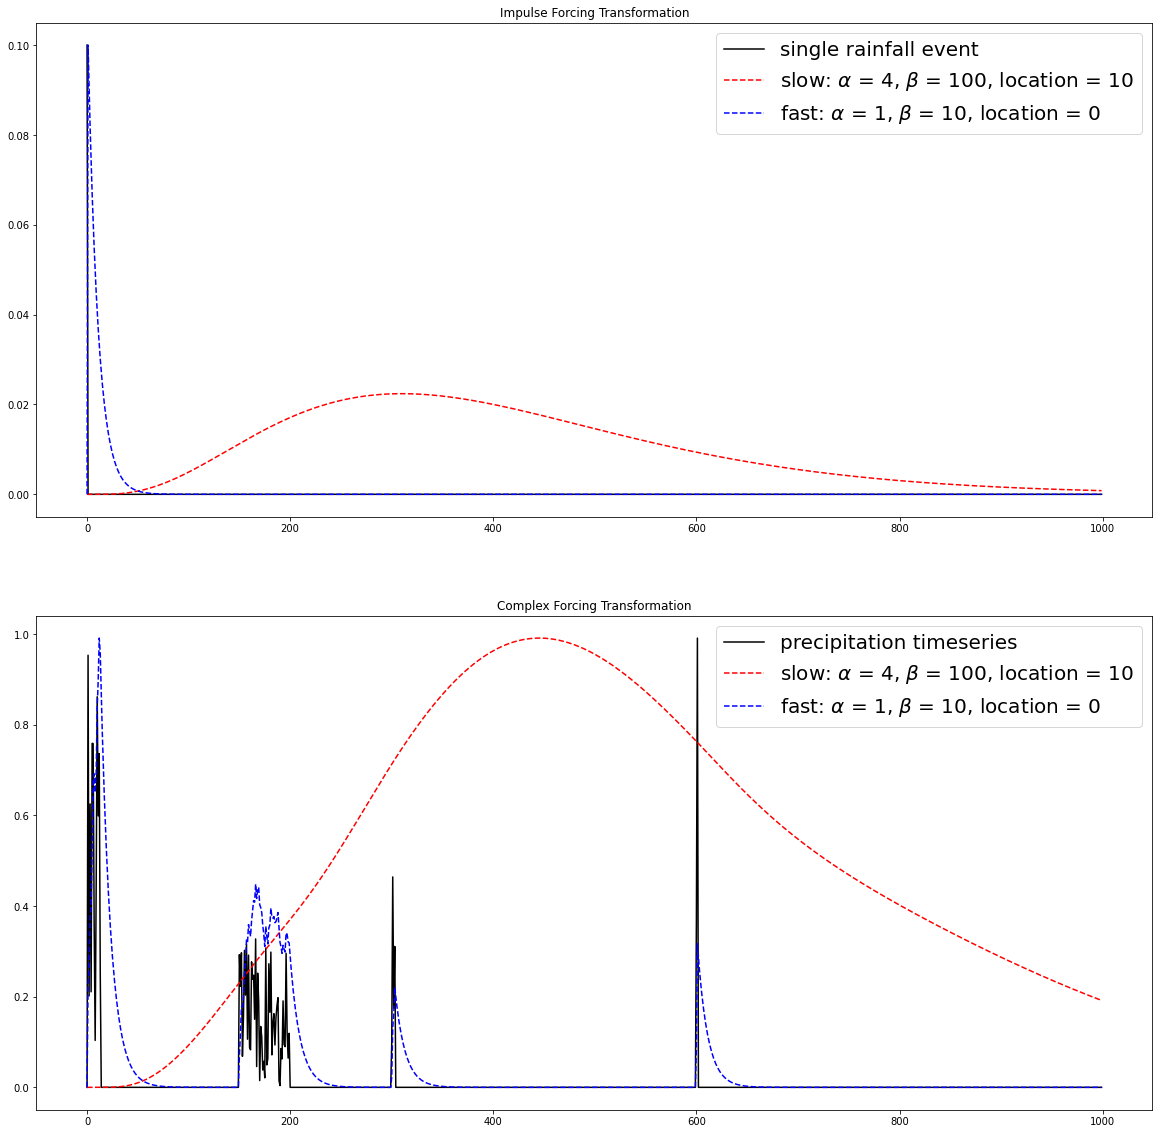

In [ ]:
impulse = np.zeros(len(t))
impulse[0] = np.max(fast)
plt.figure(figsize=(20,20))
plt.subplot(2,1,1)
plt.title("Impulse Forcing Transformation")
plt.plot(impulse, 'k',label="single rainfall event")
plt.plot(slow,'r--',label=r'slow: $\alpha$ = 4, $\beta$ = 100, location = 10')
plt.plot(fast,'b--',label=r'fast: $\alpha$ = 1, $\beta$ = 10, location = 0')
plt.legend(fontsize=20)
plt.subplot(2,1,2)
plt.title("Complex Forcing Transformation")
more_realistic = np.zeros(len(t))
more_realistic[1:14] = np.random.rand(1,13)
more_realistic[150:200] = np.random.rand(1,50)/3
more_realistic[300:304] = np.random.rand(1,4)/2
more_realistic[600:602] = np.random.rand(1,2)*2
plt.plot(more_realistic,'k',label='precipitation timeseries')
slow_realistic = transform_input([4],[100],[10],t,more_realistic)
fast_realistic = transform_input([1],[10],[0],t,more_realistic)
plt.plot(slow_realistic*np.max(more_realistic)/np.max(slow_realistic), "r--", label=r'slow: $\alpha$ = 4, $\beta$ = 100, location = 10')
plt.plot(fast_realistic*np.max(more_realistic)/np.max(fast_realistic), "b--", label=r'fast: $\alpha$ = 1, $\beta$ = 10, location = 0')
plt.legend(fontsize=20)

# optimization on 12 reservoir nash cascade

a figure of the optimization space (showing the compass search)

(12001, 2)


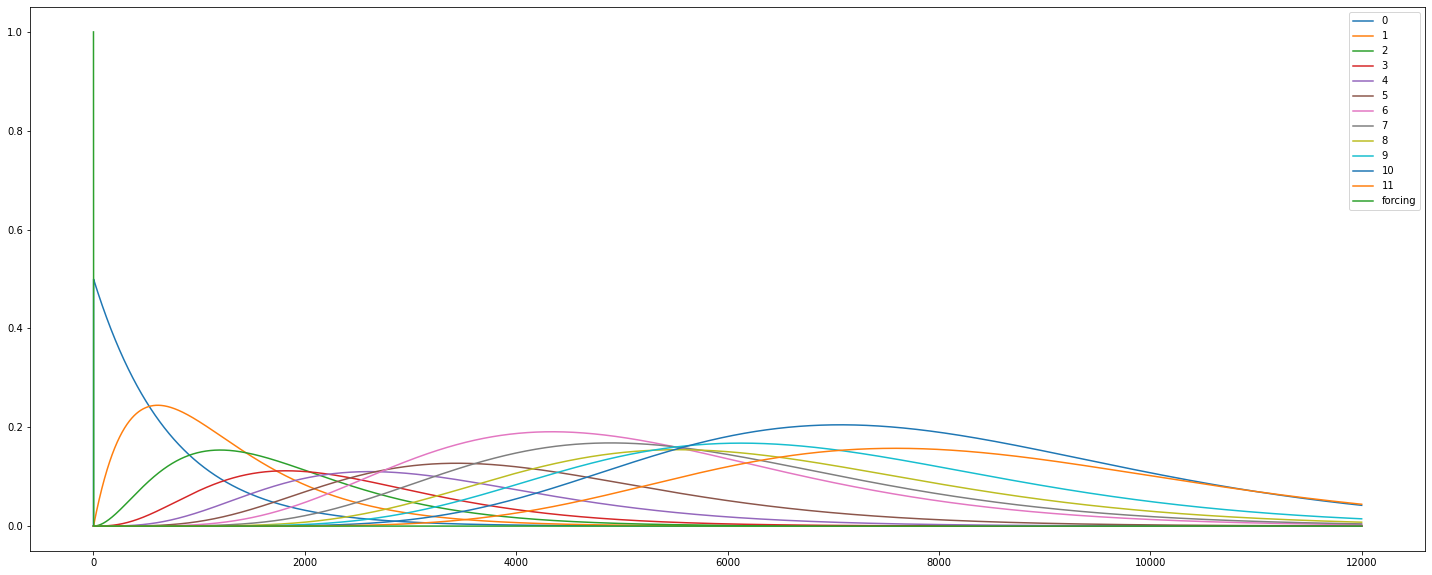

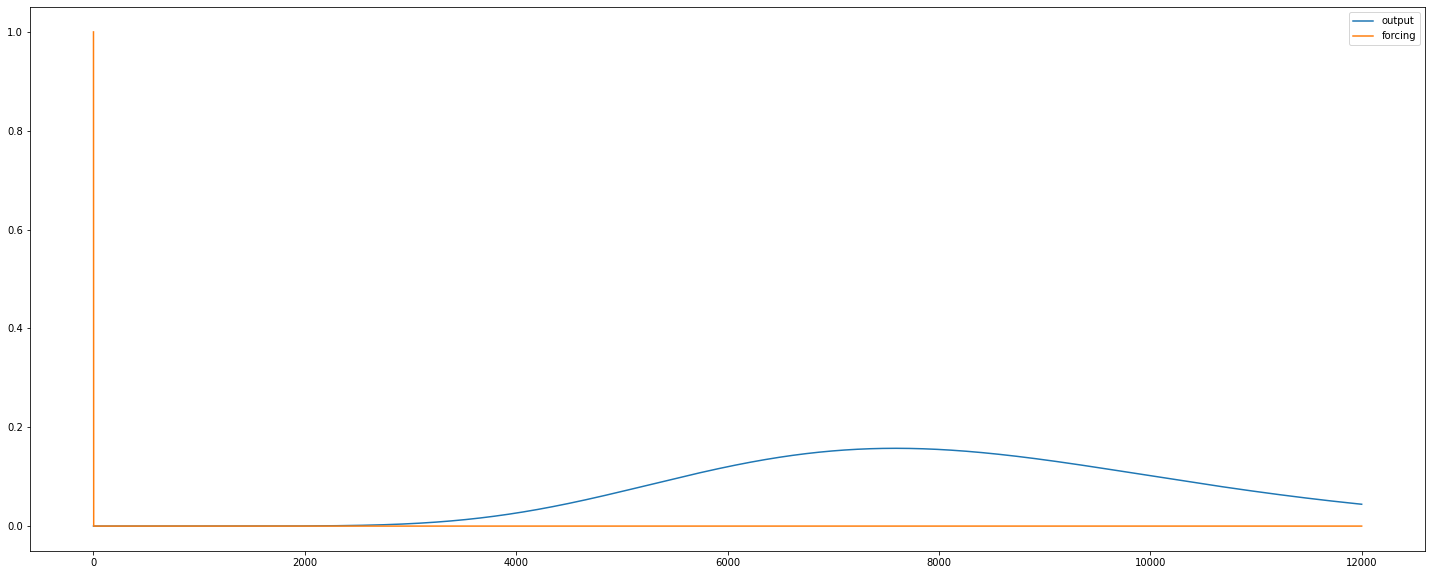

In [ ]:
np.random.seed(seed = 42)
num_states = 12
A = (-np.diag(np.ones(num_states) + np.random.rand(num_states), k=0) + 1.2*np.diag(np.ones(num_states-1) + np.random.rand(num_states -1),k=-1))/1000

B = np.concatenate((np.ones(1), np.zeros(num_states-1)))
C = np.eye(num_states)
D = np.zeros(shape=(num_states,1))
cascading_system = ct.ss(A,B,C,D)

u = np.concatenate((np.ones(1), np.zeros(num_states*1000)))

response = ct.forced_response(cascading_system,np.arange(0,len(u)),U=u)

plt.figure(figsize=(25,10))
for state in range(num_states):
  plt.plot(response.outputs[state][:], label=str(state))

plt.plot(u, label='forcing')
plt.legend()


# now, assume we can't see state 0, but only the forcing and the response
plt.figure(figsize=(25,10))
plt.plot(response.outputs[num_states-1][:], label='output')
plt.plot(u, label='forcing')
plt.legend()
X = np.concatenate((np.reshape(u,(-1,1)),np.reshape(response.outputs[num_states-1][:] , (-1,1) )),axis=1)
print(X.shape)


Initial model:

score
0.05758803744405805
shape factors
[5252.]
scale factors
[1.]
location factors
[1.]


previous, shape up, shape down, scale up, scale down, sooner, later, rounder, sharper
[0.8424343798448471, -0.016709521115564785, 0.0, -0.016709521115564785, -0.016709521115564563, 0.832115447039841, 0.8158259877558338, 0.04829857617461364, 0.0]
37
speed
50
shape factors
[26.26]
scale factors
[200.]
location factors
[485.8404]
iteration no:
3



previous, shape up, shape down, scale up, scale down, sooner, later, rounder, sharper
[0.843073346460044, -0.016709521115564785, 0.0, -0.016709521115564785, -0.016709521115561232, 0.8415079268864651, 0.842416576392991, 0.12006767247472871, 0.0]
56
speed
10
shape factors
[26.26]
scale factors
[200.]
location factors
[425.8354]
iteration no:
5



previous, shape up, shape down, scale up, scale down, sooner, later, rounder, sharper
[0.8431246652998005, -0.016709521115564785, -0.01670921261207514, 0.06703649453532978, -0.01670951998307424, 0.

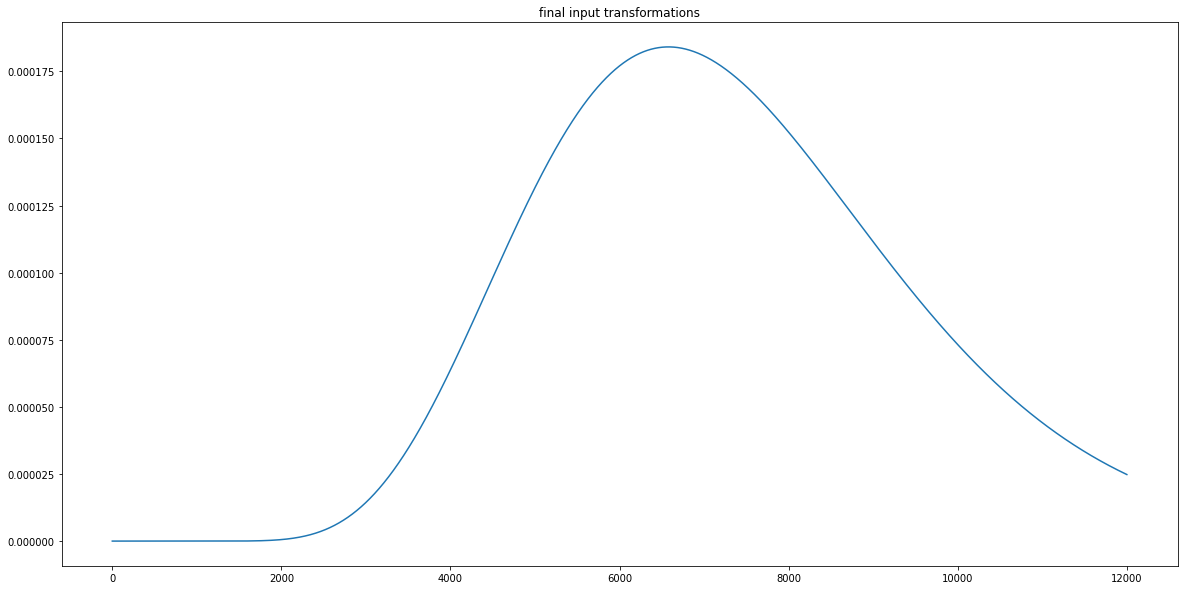

(response)' = -0.00098 response + 0.92262 forcing1
score =  0.9985512646855503


/usr/local/lib/python3.7/dist-packages/pysindy/pysindy.py:873: UserWarning: Last time point dropped in simulation because interpolation of control input was used. To avoid this, pass in a callable for u.
  "Last time point dropped in simulation because "


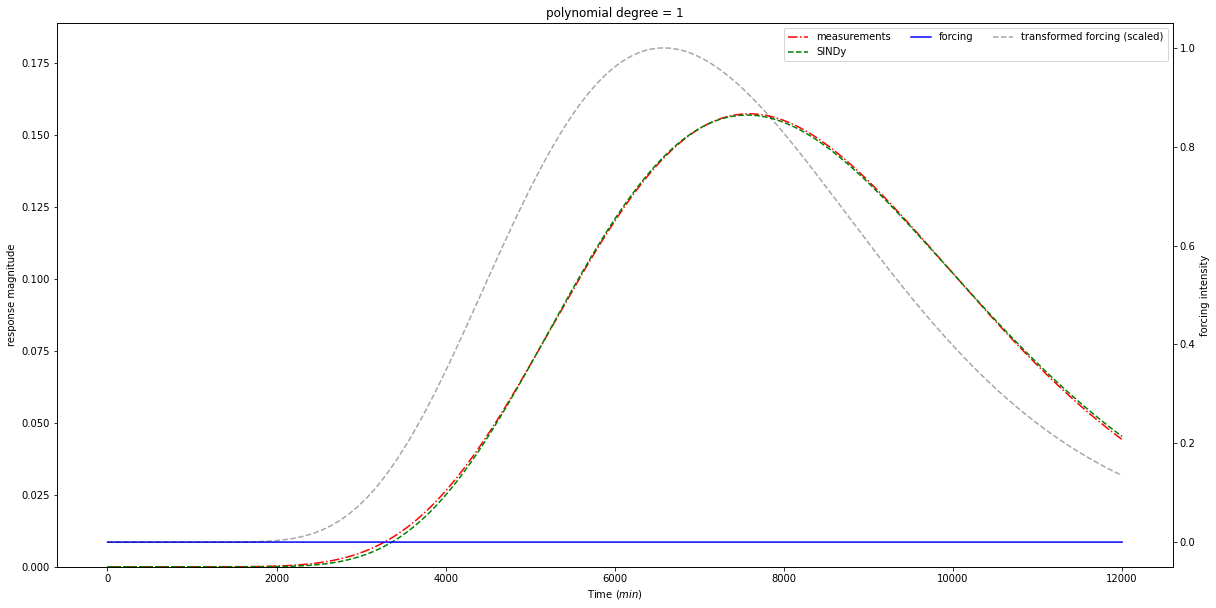

Simulation MAE =  0.0005501465684626129
Simulation RMSE =  0.0007046580333805422


In [ ]:
best_model = optimize_lag_shapes(1,1,1,2,X,1000)

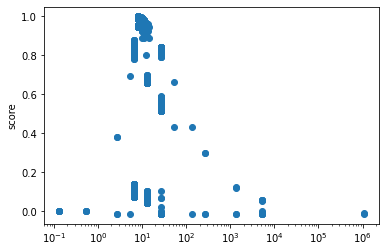

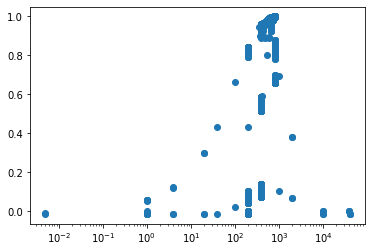

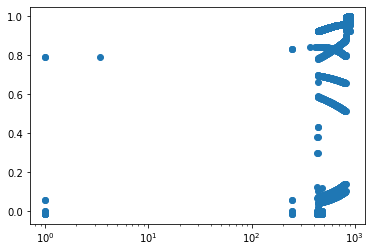

In [ ]:
scores = np.array(best_model[4])
shapes = np.array(best_model[1])
scales = np.array(best_model[2])
locations = np.array(best_model[3] )


plt.figure()
plt.ylabel("score")
plt.semilogx(shapes, scores, label='shape', marker='o',linestyle='None')
plt.figure()
plt.semilogx(scales, scores, label='scale', marker='o',linestyle='None')
plt.figure()
plt.semilogx(locations,scores, label='location', marker='o',linestyle='None')

In [ ]:
# pca down to two axes
from sklearn.decomposition import PCA

step_indices = 0,36,55,74, 84, 1498, 2066,2076,2320 


X = np.transpose(np.array((shapes,scales,locations)))

pca = PCA(n_components=2)
new_axes = pca.fit_transform(X)

print(pca.explained_variance_ratio_)

print(pca.components_)
# the third column is zero which means the location parameters is unimportant
# just use shape and scale as the axes. the impact of location in this particular optimization is negligible



[0.99559273 0.00437935]
[[ 9.99999572e-01 -6.27833905e-04 -6.80204933e-04]
 [ 6.22448253e-04  9.99968686e-01 -7.88917958e-03]]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an ar

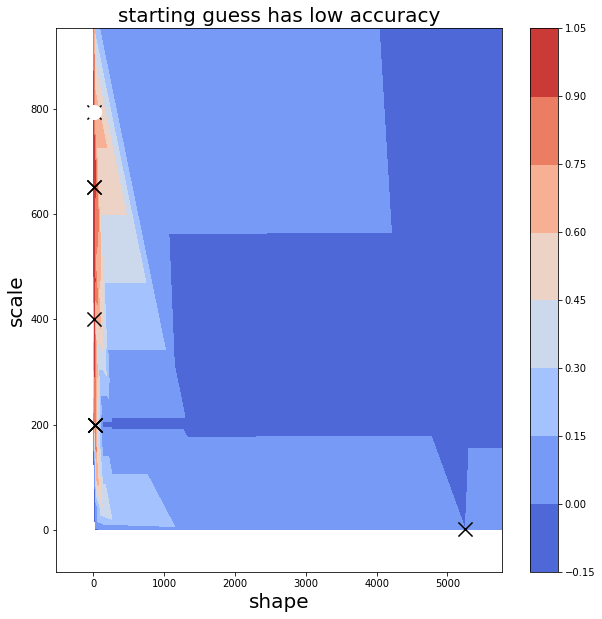

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


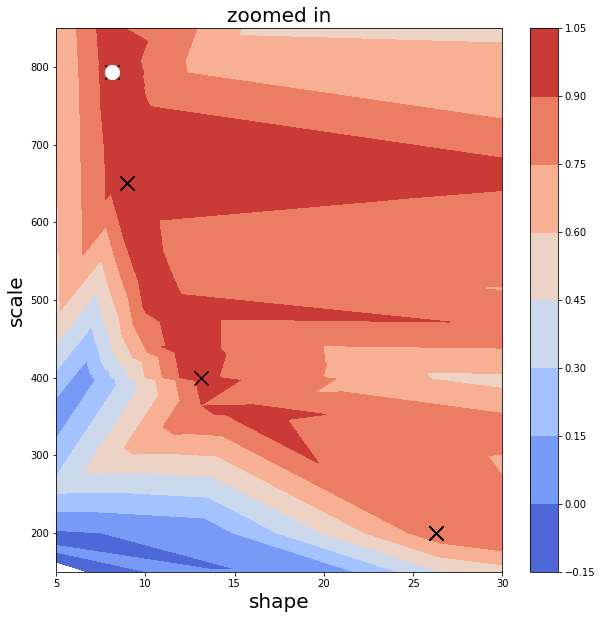

In [ ]:
marker_size = 200

# contour plot
fig = plt.figure(figsize=(10,10))
ax = plt.gca()

#ax.axes.set_yscale('log')
#ax.axes.set_xscale('log')
ax.axes.set_xlim([-0.1*max(shapes[[step_indices]]),1.1*max(shapes[[step_indices]])])
ax.axes.set_ylim([-0.1*max(scales[[step_indices]]),1.2*max(scales[[step_indices]])])
contours = ax.tricontourf(shapes,scales, scores, cmap=cm.coolwarm)
plt.xlabel("shape",fontsize=20)
plt.ylabel("scale",fontsize=20)
fig.colorbar(contours, ax = ax)
ax.scatter(shapes[[step_indices]], scales[[step_indices]], marker="x",color='k',s=marker_size)
ax.scatter(shapes[[step_indices]][-1], scales[[step_indices]][-1], marker="o",color='w',s=marker_size)
plt.title("starting guess has low accuracy",fontsize=20)
plt.show()


# contour plot
fig = plt.figure(figsize=(10,10))
ax = plt.gca()
ax.axes.set_xlim([5,30])
ax.axes.set_ylim([150,850])
contours = ax.tricontourf(shapes,scales, scores, cmap=cm.coolwarm)
plt.xlabel("shape",fontsize=20)
plt.ylabel("scale",fontsize=20)
fig.colorbar(contours, ax = ax)
ax.scatter(shapes[[step_indices]], scales[[step_indices]], marker="x",color='k',s=marker_size)
ax.scatter(shapes[[step_indices]][-1], scales[[step_indices]][-1], marker="o",color='w',s=marker_size)
plt.title("zoomed in",fontsize=20)
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in 

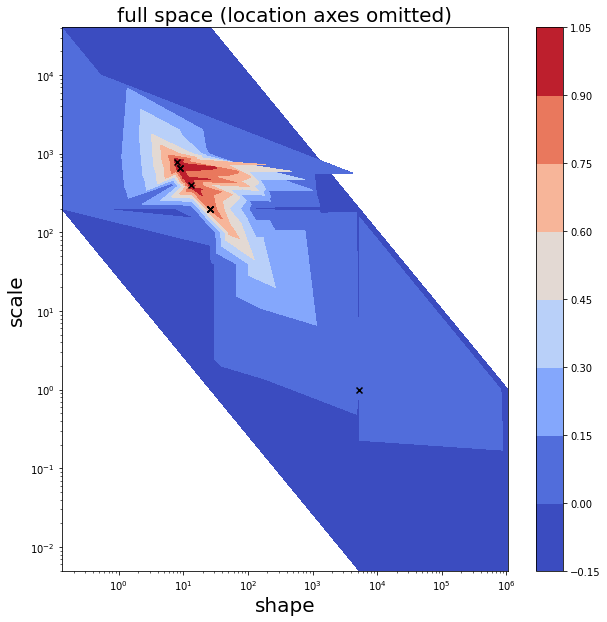

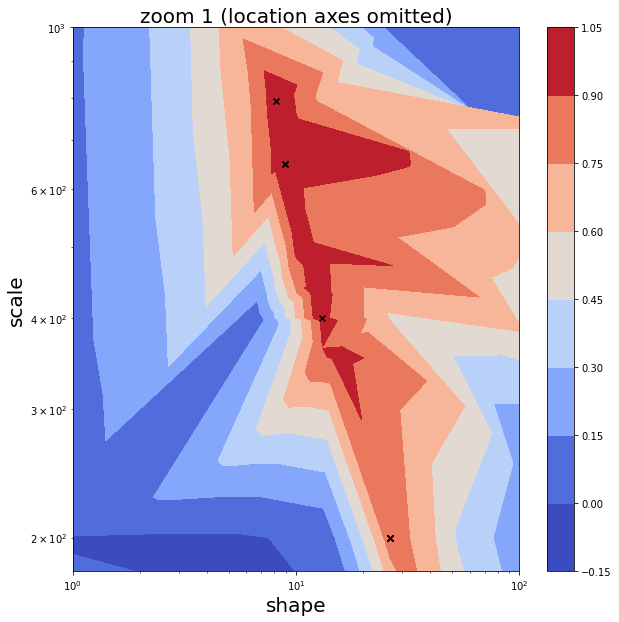

In [ ]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib as mpl


scores = np.array(best_model[4])
shapes = np.array(best_model[1])
scales = np.array(best_model[2])
locations = np.array(best_model[3] )

shape_steps = shapes[[step_indices ]]
scale_steps = scales[[step_indices  ]]
location_steps = locations[[step_indices ]]
#print(shape_steps) # shape happens to not change from starting guess for this optimization
#print(scale_steps)
#print(location_steps)


violation_indices = np.where(scores <= 0)
#print(violation_indices)



#scales = np.delete(scales, violation_indices)
#locations = np.delete(locations, violation_indices)
#scores = np.delete(scores,violation_indices)


# contour plot
fig = plt.figure(figsize=(10,10))
ax = plt.gca()
ax.axes.set_yscale('log')
ax.axes.set_xscale('log')
#ax.axes.set_xlim([1,1000])
contours = ax.tricontourf(shapes,scales, scores, cmap=cm.coolwarm, vmin=0, vmax=1)
plt.xlabel("shape",fontsize=20)
plt.ylabel("scale",fontsize=20)
fig.colorbar(contours, ax = ax )

# commenting out arrows for now because optimization space isn't actually 2d
'''
u = np.diff(shape_steps)
v = np.diff(scale_steps)
pos_x = shape_steps[:-1] #+ u/2
pos_y = scale_steps[:-1] #+ v/2
norm = np.sqrt(u**2+v**2) 
print(norm)
ax.plot(shape_steps, scale_steps, marker="o",color='k')
ax.quiver(pos_x, pos_y, u/norm, v/norm, angles="uv", zorder=5, pivot="mid",color='k')
'''
ax.scatter(shape_steps, scale_steps, marker="x",color='k')
plt.title("full space (location axes omitted)",fontsize=20)
plt.show()


# contour plot
fig = plt.figure(figsize=(10,10))
ax = plt.gca()
ax.axes.set_yscale('log')
ax.axes.set_xscale('log')
ax.axes.set_xlim([1,100])
ax.axes.set_ylim([180,1000])
contours = ax.tricontourf(shapes,scales, scores, cmap=cm.coolwarm, vmin=0, vmax=1)
plt.xlabel("shape",fontsize=20)
plt.ylabel("scale",fontsize=20)
fig.colorbar(contours, ax = ax )

ax.scatter(shape_steps, scale_steps, marker="x",color='k')
plt.title("zoom 1 (location axes omitted)",fontsize=20)
plt.show()



ValueError: ignored

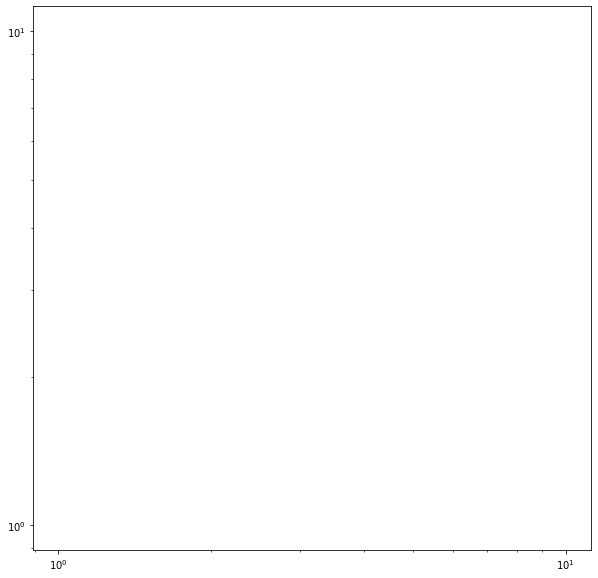

In [ ]:
plt.figure(figsize=(10,10))
ax = plt.gca()
ax.axes.set_yscale('log')
ax.axes.set_xscale('log')
points = plt.scatter(shapes,scales,c=scores)
fig.colorbar(points, ax = ax)
plt.title("entire optimization")


plt.figure(figsize=(10,10))
ax = plt.gca()
ax.axes.set_xlim([0.4,1.2])
ax.axes.set_ylim([100,160])
points = plt.scatter(shapes,scales,c=scores)
fig.colorbar(points, ax = ax)
plt.title("entire optimization")

In [ ]:
# interpolate across a regular grid to generate a contour map of scores




In [ ]:

# plot a heatmap of scales and locations with scores on top


plt.figure(figsize=(10,10))


plt.gca().invert_yaxis()


# add markers for where trials actually took place

